# Part 1: Donald Trump Communication Analysis on Twitter

## Import packages

In [1]:
import pyspark 

In [2]:
pip install clean-text

     |████████████████████████████████| 51 kB 374 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 365 kB/s eta 0:00:01
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49713 sha256=b5cac9a66acc4685bff7b363ee0ce1a0e376dc85e0bcff4273abdda397a7b790
  Stored in directory: /home/jovyan/.cache/pip/wheels/43/3d/82/e7baffa5e86346c6178d7750dba6e8ef063282a37fc563f8f8
  Created wheel for ftfy: filename=ftfy-5.8-py3-none-any.whl size=45612 sha256=22a3bd5a0700002c9679c27bd0a1e34f39217e5c3cf2262625425e9b50d173f0
  Stored in directory: /home/jovyan/.cache/pip/wheels/3f/a5/65/684a672b6a26cb8ce3934d155c98d0e23b3dce3d2c0fadae19
Successfully built emoji ftfy
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install wordcloud

     |████████████████████████████████| 371 kB 354 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install regex

     |████████████████████████████████| 738 kB 257 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install datefinder

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install nltk

     |████████████████████████████████| 1.4 MB 382 kB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=9ee5aafca6ec4b341cc34ffc6ee288e9952e9c1e393d9f801f552d11f312c089
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk
Note: you may need to restart the kernel to use updated packages.


In [7]:
import statistics
import datefinder
import matplotlib.pyplot as plt

In [8]:
import datetime
from datetime import date
import re
import pandas as pd
import emoji
import regex

In [9]:
import nltk
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [10]:
nltk.download('vader_lexicon')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA_en

In [12]:
vds_en = SIA_en()

## Data preparation

In [13]:
sc = pyspark.SparkContext(appName="Spark RDD")

We import the data from our text file and we delete the empty tweets

In [14]:
# first read the mbox.txt file into the RDD rdd_mbox

rdd_mbox = sc.textFile('data/trump_tweets.txt')
rdd_mbox = rdd_mbox.filter(lambda x: x != '') 

In [15]:
nb_twitter = rdd_mbox.count()

### Data features extractions

#### Function definition

We create the functions we will use in the future 

The function check_startwith verify if a tweet begin with a word or a character

In [16]:
def check_startwith(tweet,start) :
    if tweet.startswith(start) == True :
        return True
    else :
        return False

The function find_date extract the date from a tweet

In [17]:
def find_date(tweet) :
    matches = list(datefinder.find_dates(tweet))
    if len(matches) > 0:
        date_ = matches[0]
    else : 
        date_ = None
    return date_

The function extract_url extract urls from a tweet

In [18]:
def extract_url(tweet) :
    url = re.findall(r'(https?://[^\s]+)',str(tweet.split(';')[0]))
    return url

The function extract_stractwith extract the word or the character we want

In [19]:
def extract_startwith(tweet,start) :
    list_word = list()
    for word in tweet.split(' ') :
        if word.startswith(start) == True :
            select_word = word[1:]
            list_word.append(select_word)
    return list_word

The function verify_emoji verify if there are emojis in the tweets

In [20]:
def verify_emojis(tweet):
    for emoji_tweet in tweet :
        if emoji_tweet  in emoji.UNICODE_EMOJI :
            return True
    return False

The function extract_emoji extract emoji from tweets

In [21]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [22]:
def verify_startwith(tweet,start) :
    list_word = list()
    for word in tweet.split(' ') :
        if word.startswith(start) == True :
            return True 
    return False

In [23]:
def replace_words(tweet_words, list_replace, replacement_word) :
    for i in range(len(tweet_words)) :
        if tweet_words[i] in list_replace :
            tweet_words[i] = replacement_word

This function clean the extraction from the twitter user who is retweeted

In [24]:
def clean_rt(RT):
    if RT.endswith(":") ==True :
        RT = RT.replace(":","")
    elif RT.endswith(".") ==True :
        RT = RT.replace(".","")
    return RT

This function verify if a value is in a tweet

In [25]:
def verify_(tweet, value_) :
    if value_ in tweet :
        return True 
    else :
        return False

This function clean the tweet by : 
- first removing :
    - emoji
    - hastag
    - RT from
- Secondly :
    - lowering the letter
    - removing punctuation
    - removing number

In [26]:
def clean_tweet_(tweet) :
    clean_tweet = tweet
    List_emoji = extract_emojis(clean_tweet)
    List_hastag = extract_startwith(clean_tweet,'#')
    List_from =  extract_startwith(clean_tweet,'@')
    
    if check_startwith(clean_tweet, 'RT')== True or check_startwith(clean_tweet, '"RT')== True  :
        for from_ in List_from :
            clean_tweet = clean_tweet.replace(from_, '')
            clean_tweet = clean_tweet.replace('RT', '')
    
    if verify_emojis(tweet)== True:
        for emoji_ in List_emoji :
            clean_tweet = clean_tweet.replace(emoji_,'')
    
    if verify_startwith(tweet,'#')== True :
        for hastag_ in List_hastag :
            clean_tweet = clean_tweet.replace(hastag_,'')
    
    clean_tweet = clean(clean_tweet,
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks as opposed to only normalizing them
        no_urls=True,                  # replace all URLs with a special token
        no_numbers=True,               # replace all numbers with a special token
        no_punct=True,                 # remove punctuations
        replace_with_punct="",          # instead of removing punctuations you may replace them
        replace_with_url="",
        replace_with_number="",
        lang="en"                       # set to 'de' for German special handling
)
    return clean_tweet

#### Data extraction

We identitify if it is a retweet or not

In [27]:
RT = rdd_mbox.map(lambda tweet : check_startwith(tweet, 'RT'))

We extract the date

In [28]:
Date_ = rdd_mbox.filter(lambda tweet : verify_(tweet,';')==True) \
                .map(lambda tweet : tweet.split(';')[1]) \
                .map(lambda tweet : find_date(tweet)) 

In [29]:
Year_ = rdd_mbox.filter(lambda tweet : verify_(tweet,';')==True) \
                .map(lambda tweet : tweet.split(';')[1]) \
                .map(lambda tweet : find_date(tweet).year) \
                .filter(lambda year_ :(year_<2021)and(year_>2000) )

We extract the time

In [30]:
Time_ = rdd_mbox.map(lambda tweet : find_time(tweet))

We extract urls

In [31]:
URL = rdd_mbox.map(lambda tweet : extract_url(tweet))

We extract hastags

In [32]:
hastag = rdd_mbox.flatMap(lambda tweet : extract_startwith(tweet,'#'))

We extract the user from who Trump retweet

In [33]:
RT_from = rdd_mbox.flatMap(lambda tweet :extract_startwith(tweet,'@'))

In [34]:
RT_from = RT_from.map (lambda tweet :clean_rt(tweet))

We extract emojis

In [35]:
emoji_ = rdd_mbox.flatMap(lambda tweet : extract_emojis(tweet))

## Data transformartion

We transform our tweet to clean and processable sentence and list of words

In [36]:
rdd_clean_tweet = rdd_mbox.filter(lambda tweet : verify_(tweet,';')==True) \
                        .map(lambda tweet : clean_tweet_(tweet))

In [37]:
nb_twitter_clean = rdd_clean_tweet.count()

In [38]:
rdd_clean_tweet_words = rdd_mbox.filter(lambda tweet : verify_(tweet,';')==True) \
                                .map(lambda tweet : clean_tweet_(tweet).split(' '))

## Stopwords

We remove stop words from our tweet. Therefore we load the text file with all our stop words.

In [39]:
content = open("data/stop-words.txt", "r").readlines()
stop_words_ = []
for element in content:
    stop_words_.append(element.strip())

Then we create a function that filter stop word in a list of words 

In [40]:
def remove_stop_words(tweet_words) :
    filtered_sent=[] 
    for w in tweet_words :
        if w not in stop_words_ :
            if w != '':
                filtered_sent.append(w)
    return  filtered_sent

In [41]:
rdd_clean_tweet_stop_words = rdd_clean_tweet_words.map(lambda tweet_words : remove_stop_words(tweet_words))

In [42]:
rdd_clean_tweet_stop_words_flat = rdd_clean_tweet_words.flatMap(lambda tweet_words : remove_stop_words(tweet_words))

## Plot functions

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

We define a function to plot word cloud

In [104]:
def plot_cloud(list_):
    wordcloud = WordCloud(width = 1500, height = 500, random_state=1, background_color='white', colormap='Set2', collocations=False).generate_from_frequencies(dict(list_))
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    plt.show();

We define a function to plot opinion

In [45]:
def plot_opinion(list_positives, list_negatives):
    
    list_1 = [(t[0], t[1], 'positive') for t in list_positives]
    list_2 = [(t[0], t[1], 'negative') for t in list_negatives]
    
     
    list_1.extend(list_2)
    
    
    df_opinion = pd.DataFrame({
     'Opinion': [ t[0] for t in list_1 ],
     'Count': [ t[1] for t in list_1 ],
     'polarity': [ t[2] for t in list_1 ]
    }).sort_values('Count', ascending=False)
    
    df_opinion['color'] = df_opinion.polarity.apply(lambda polarity: 'green' if polarity=='positive' else 'red')
    
    plt.figure( figsize = (15, 8) )
    chart=sb.barplot(data=df_opinion, x='Opinion', y='Count', hue='polarity', palette=["green", "red"], order=df_opinion['Opinion'])
    chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=80, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
    )
    
    for tick, color in zip(chart.get_xticklabels(), df_opinion['color']): 
        tick.set_color(color)
    
    plt.show()

We define a function to plot_contextual_words by ploting a bar chart presenting top contextual words

In [46]:
def plot_words(list_contextual_words):
    
    pd_df = pd.DataFrame({
        'Word':  [ t[0] for t in list_contextual_words ],
        'Count': [ t[1] for t in list_contextual_words ]
    }).sort_values('Count', ascending=False)
    
    plt.figure( figsize = (15, 8) )
    
    chart=sb.barplot(data=pd_df, x='Word', y='Count', order=pd_df['Word'], color='blue')
    
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=80, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large',
        )
    
    plt.show()

## Overall sentiment analysis

We analyse the overall sentiment of one tweet using the vador function from NLTK packages, which allows to give a score for each sentence by scoring each word. First we create a function that analyse a tweet then we apply it to our rdd.

In [47]:
def sentiment_analysis_(tweet) :
    x = 0
    score_list = list()
    sentiment_output = ""
    
    score = vds_en.polarity_scores(tweet)
    score_ = score['compound']
       
    if score_ >= 0.05 :
        sentiment_output = 'positive'
    elif score_ <=-0.05:
        sentiment_output  = 'negative'
    else :
        sentiment_output  = 'neutral' 
        
    return sentiment_output

In [48]:
rdd_sentiment_analysis = rdd_clean_tweet.map(lambda tweet : sentiment_analysis_(tweet))

We initialize an rdd with key/value for counting each positive, neutral and negative results in our rdd.
Then we use the mapValues transformation to assign a default count of 1 for each result.
Sentiment_count_kv should contain the number of occurences (count) of positives, negatives and neutrals results.
Sentiment_count_kv_ordered should contain the previous RDD in descending order based on the count

In [49]:
Sentiment_kv = rdd_sentiment_analysis.map(lambda word: (word, 1))
Sentiment_kv = Sentiment_kv.mapValues(lambda tuple: 1)
Sentiment_count_kv = Sentiment_kv.reduceByKey(lambda x,y : x+y)
Sentiment_count_kv_ordered = Sentiment_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
Top_sentiment = Sentiment_count_kv_ordered.take(3)

Finally we plot our result with a pie chaet

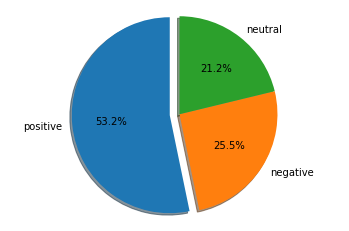

In [50]:
Sentiment_1 = Top_sentiment[0][0]
Sentiment_2 = Top_sentiment[1][0]
Sentiment_3 = Top_sentiment[2][0]
Sentiment_score_1 = (Top_sentiment[0][1]/nb_twitter)*100
Sentiment_score_2 = (Top_sentiment[1][1]/nb_twitter)*100
Sentiment_score_3 = (Top_sentiment[2][1]/nb_twitter)*100

labels = Sentiment_1, Sentiment_2, Sentiment_3
sizes = [Sentiment_score_1, Sentiment_score_2, Sentiment_score_3]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Words sentiment analysis

We initialize an rdd with key/value for counting each word in the file 

In [51]:
rdd_clean_tweet_stop_words_kv = rdd_clean_tweet_stop_words_flat.map(lambda word: (word, 1))

#### Positives words

In [52]:
rdd_positive_words = sc.textFile('data/positive-words.txt')

In [53]:
rdd_positive_words_kv = rdd_positive_words.map(lambda word: (word, 1))

In [54]:
rdd_positive_words_tweet_kv = rdd_clean_tweet_stop_words_kv.join(rdd_positive_words_kv)

In [55]:
rdd_positive_words_tweet_kv = rdd_positive_words_tweet_kv.mapValues(lambda tuple: 1)

In [56]:
rdd_positive_words_tweet_count_kv = rdd_positive_words_tweet_kv.reduceByKey(lambda x,y : x+y)

In [57]:
rdd_positive_words_tweet_count_kv_ordered = rdd_positive_words_tweet_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_positives_words = rdd_positive_words_tweet_count_kv_ordered.take(25)

#### Negatives words

In [58]:
rdd_negative_words = sc.textFile('data/negative-words.txt')

In [59]:
rdd_negative_words_kv = rdd_negative_words.map(lambda word: (word, 1))

In [60]:
rdd_negative_words_tweet_kv = rdd_clean_tweet_stop_words_kv.join(rdd_negative_words_kv)

In [61]:
rdd_negative_words_tweet_kv = rdd_negative_words_tweet_kv.mapValues(lambda tuple: 1)

In [62]:
rdd_negative_words_tweet_count_kv = rdd_negative_words_tweet_kv.reduceByKey(lambda x,y : x+y)


In [63]:
rdd_negative_words_tweet_count_kv_ordered = rdd_negative_words_tweet_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_negatives_words = rdd_negative_words_tweet_count_kv_ordered.take(25)

## Visualizing polarized opinions from tweets

We visualize the positives and negatives words most used by Donald Trump Jr

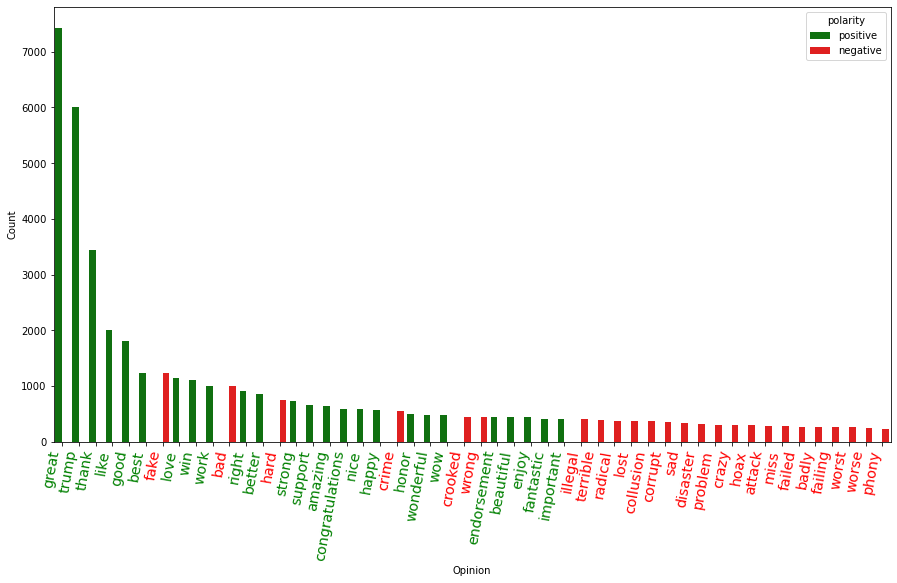

In [64]:
plot_opinion(list_top_positives_words, list_top_negatives_words)

## Contextual words

We focus on contextual_words

In [65]:
contextual_words = rdd_clean_tweet_stop_words_flat.subtract(rdd_negative_words).subtract(rdd_positive_words)

In [66]:
contextual_words_count_ordered = contextual_words.map(lambda word: (word, 1))\
                                                 .reduceByKey(lambda x,y : x+y)\
                                                 .sortBy(lambda tuple: tuple[1], ascending=False)

list_top_contextual_words = contextual_words_count_ordered.take(50)  

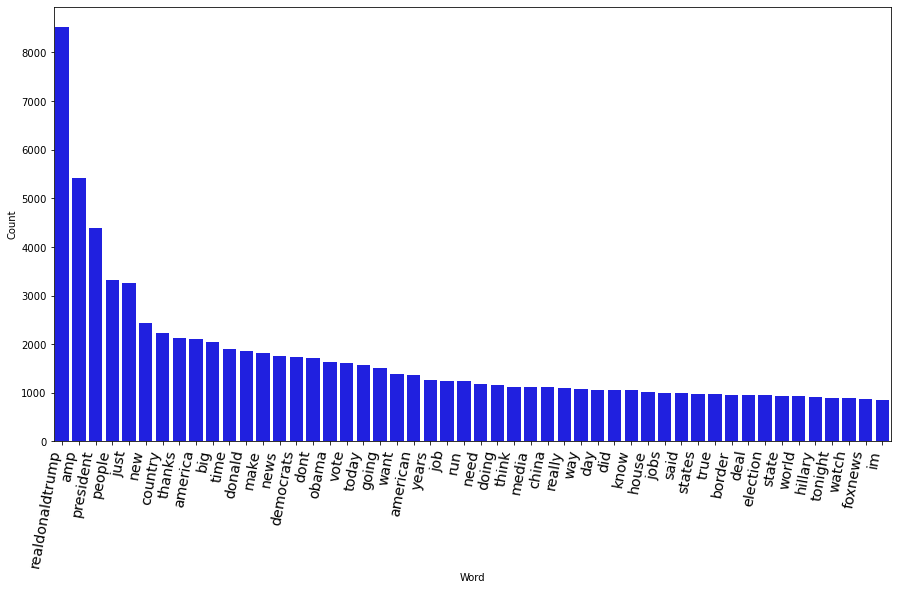

In [67]:
plot_words(list_top_contextual_words)

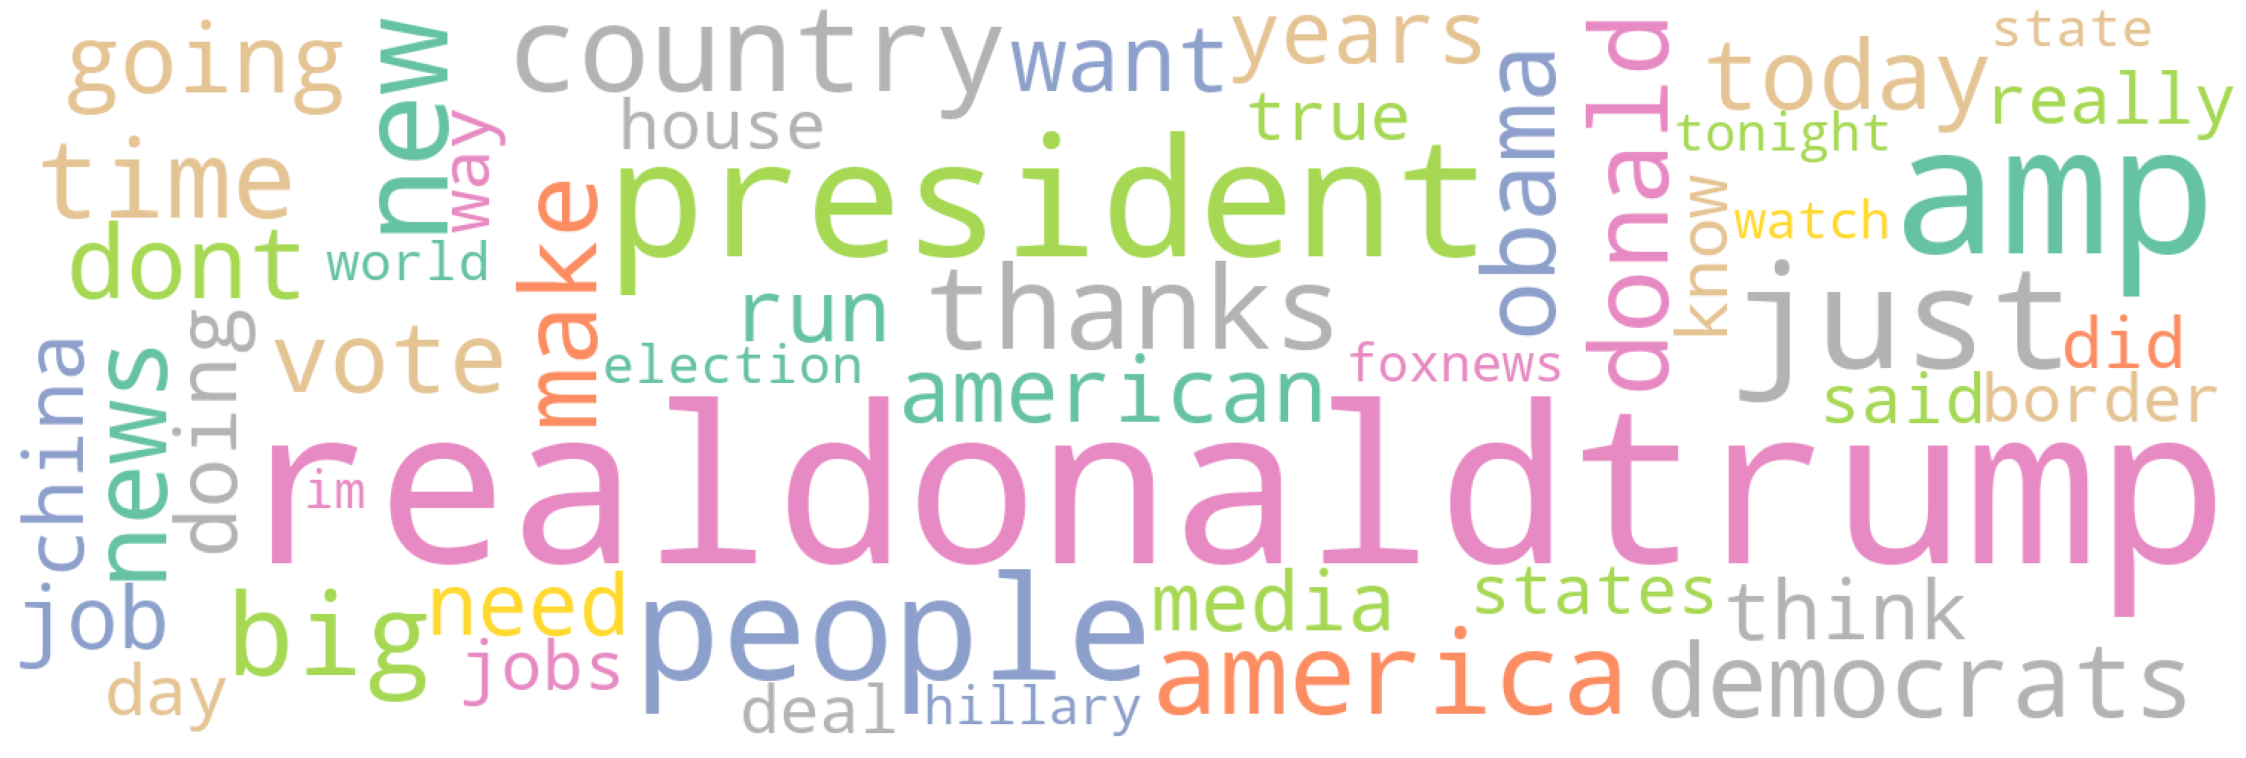

In [68]:
plot_cloud(list_top_contextual_words)

## Hastag analysis

We visualize the hastag most used by Donald Trump Jr

In [69]:
hastag_kv= hastag.map(lambda word: (word, 1))
hastag_kv = hastag_kv.mapValues(lambda tuple: 1)
hastag_count_kv = hastag_kv.reduceByKey(lambda x,y : x+y)
hastag_count_kv_ordered = hastag_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_hastag = hastag_count_kv_ordered.take(25)

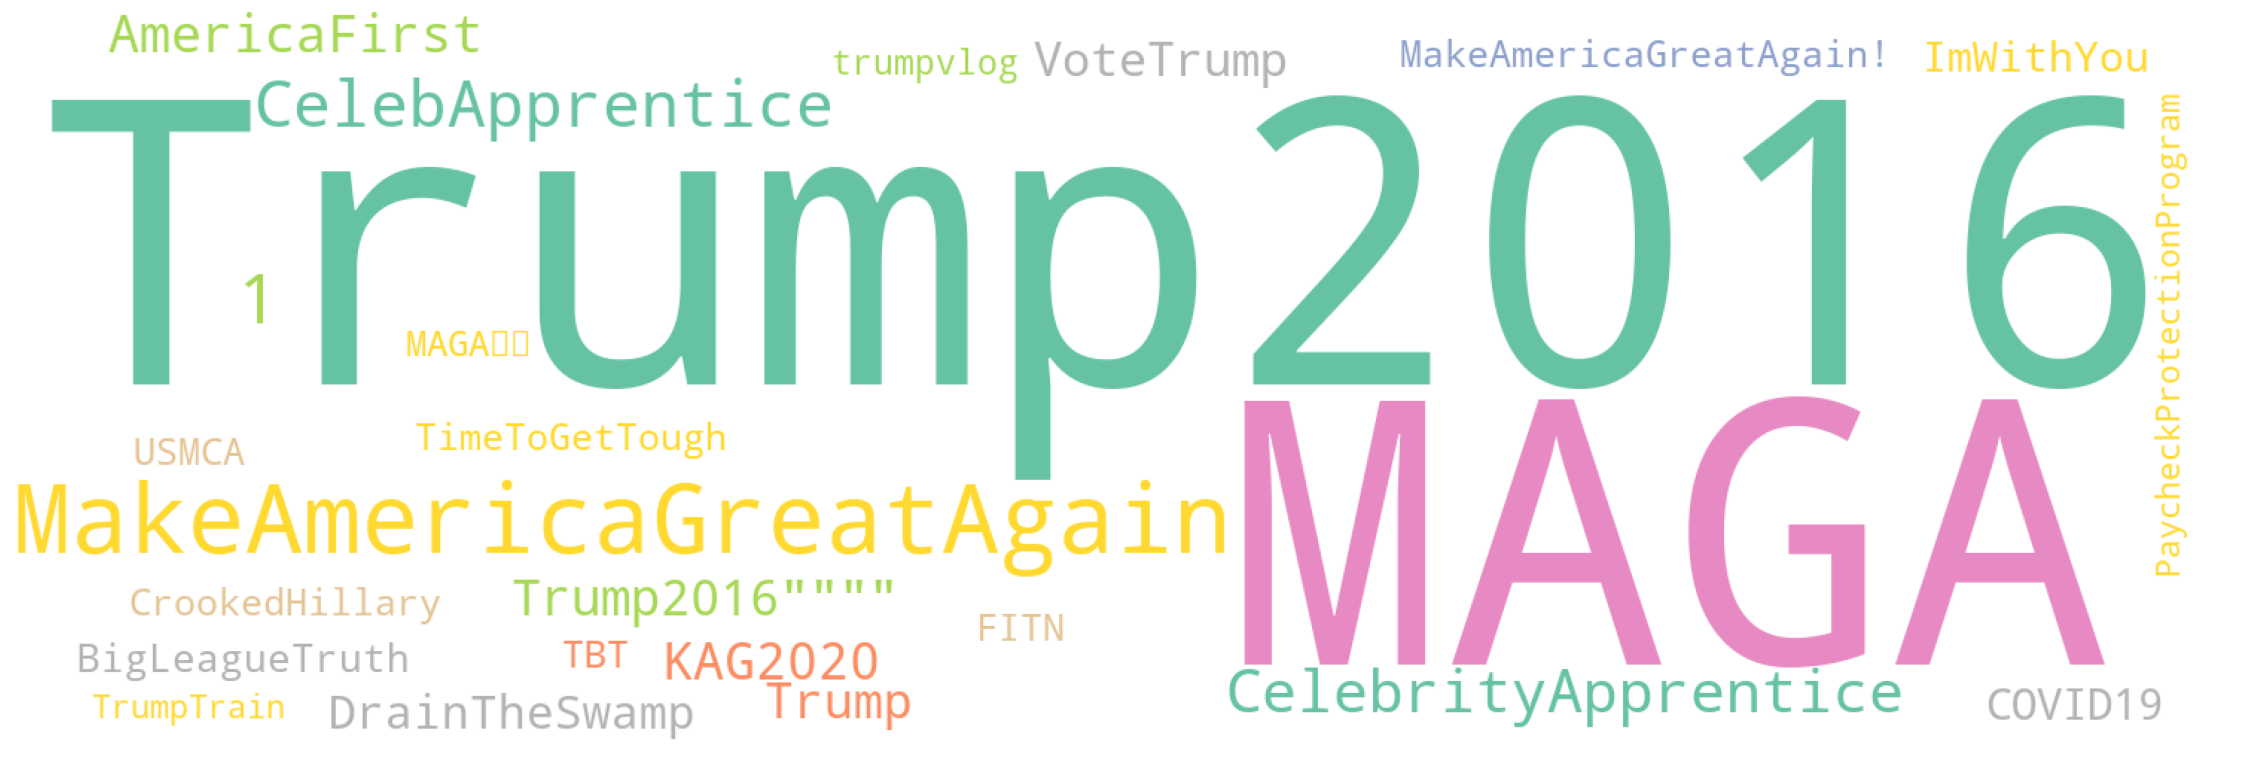

In [70]:
plot_cloud(list_top_hastag)

## Retweet analysis

We visualize the retweets most used by Donald Trump Jr

In [71]:
RT_from_kv = RT_from.map(lambda word: (word, 1))
RT_from_kv = RT_from_kv.mapValues(lambda tuple: 1)
RT_from_count_kv = RT_from_kv.reduceByKey(lambda x,y : x+y)
RT_from_count_kv_ordered = RT_from_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_retweet_from = RT_from_count_kv_ordered.take(25)

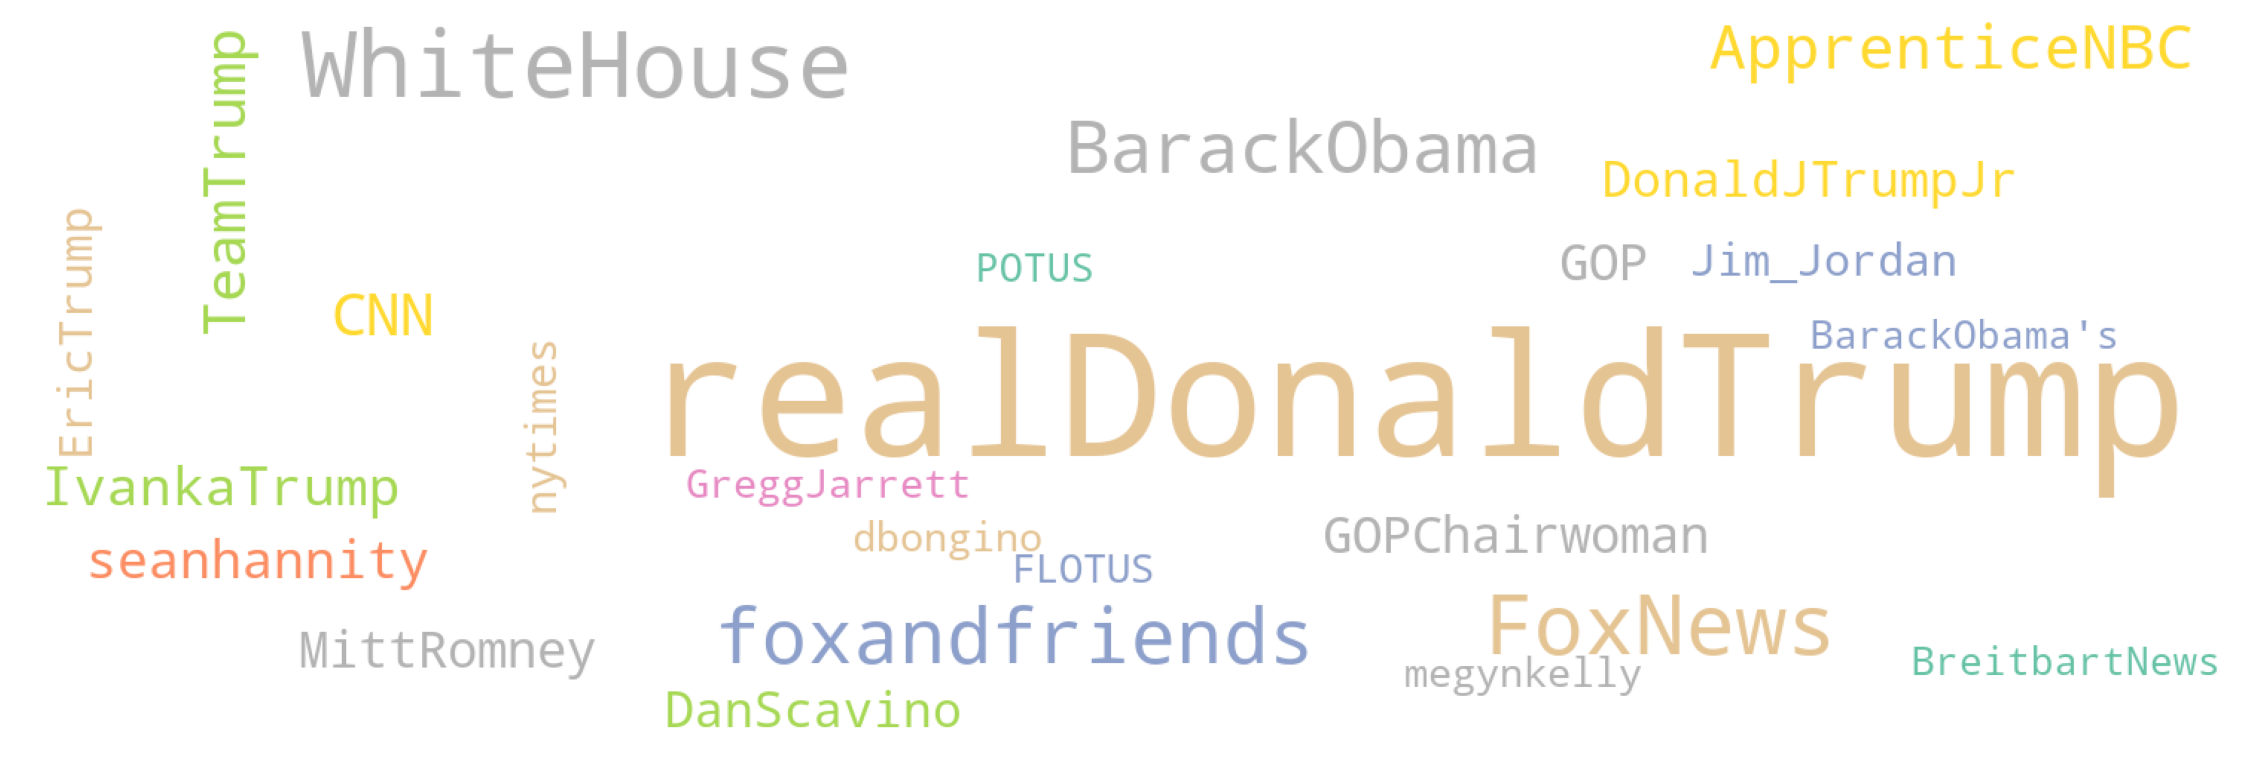

In [72]:
plot_cloud(list_top_retweet_from)

## Emoji analyis

We visualize the emojis most used by Donald Trump Jr

In [73]:
emoji_kv = emoji_.map(lambda word: (word, 1))
emoji_kv = emoji_kv.mapValues(lambda tuple: 1)
emoji_count_kv = emoji_kv.reduceByKey(lambda x,y : x+y)
emoji_count_kv_ordered = emoji_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_top_emoji = emoji_count_kv_ordered.take(25)
list_top_emoji

[('🇺', 557),
 ('🇸', 550),
 ('🚨', 133),
 ('✅', 89),
 ('👍', 73),
 ('➡', 71),
 ('👇', 66),
 ('🏻', 59),
 ('❤', 45),
 ('🔥', 37),
 ('🤣', 32),
 ('⬇', 32),
 ('❌', 31),
 ('😂', 29),
 ('👏', 28),
 ('🙏', 26),
 ('🙌', 23),
 ('🇵', 23),
 ('🏼', 20),
 ('🎥', 19),
 ('💯', 18),
 ('🇯', 16),
 ('🇷', 15),
 ('▶', 15),
 ('✔', 14)]

# Retweet analysis

We focus on the distribution of retweets 

In [74]:
RT_kv = RT.map(lambda word: (word, 1))
RT_kv = RT_kv.mapValues(lambda tuple: 1)
RT_count_kv = RT_kv.reduceByKey(lambda x,y : x+y)
RT_count_kv_ordered = RT_count_kv.sortBy(lambda tuple: tuple[1], ascending=False)
list_RT = RT_count_kv_ordered.take(2)
list_RT

[(False, 49719), (True, 7774)]

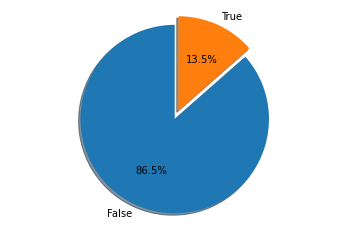

In [75]:
RT_1 = list_RT[0][0]
RT_2 = list_RT[1][0]

RT_1_frequency = (list_RT[0][1]/nb_twitter)*100
RT_2_frequency = (list_RT[1][1]/nb_twitter)*100

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = RT_1, RT_2
sizes = [RT_1_frequency, RT_2_frequency]
explode = (0.1, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Frequency tweets

We are looking at the frequency of tweeting per year

In [76]:
Year_kv = Year_.map(lambda Year_: (Year_, 1))
Year_kv = Year_kv.mapValues(lambda tuple: 1)
Year_count_kv = Year_kv.reduceByKey(lambda x,y : x+y)
Year_count_kv_ordered = Year_count_kv.sortBy(lambda tuple: tuple[1])
list_frequency = Year_count_kv_ordered.take(20)

<BarContainer object of 12 artists>

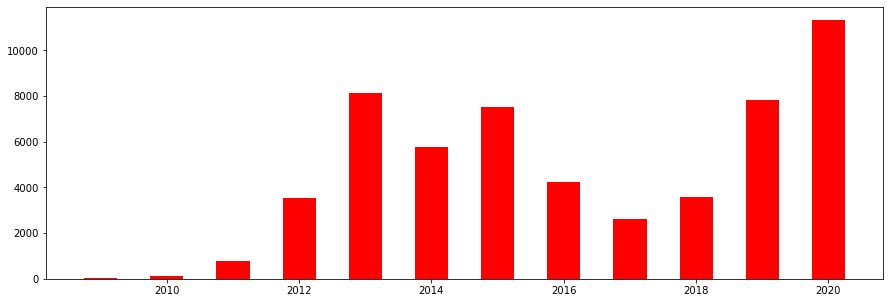

In [77]:
dict_frequency = dict(list_frequency)
plt.figure(figsize=(15,5))
plt.bar(dict_frequency.keys(), dict_frequency.values(), width=.5, color='r')

# Classifier 

In [78]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

Since we wanted to have fun, we decided to predict whether Trump's tweet was done while he was president or before.
We create a label that is true if the tweet is sent after 2016 and false in the other case. 
Then we split our dataset to test our model.

In [79]:
def split_data(contents, labels):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
    
    for train_index, test_index in splitter.split(contents, labels):
            # Notice we're not splitting at a specific index but passing an array withindices were assigning to each set
            # '_pre_vectorize' here reminds me this data has not yet been converted into tf-idf features
            X_train_pre_vectorize, X_test_pre_vectorize = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

    return X_train_pre_vectorize, y_train, X_test_pre_vectorize, y_test

In [80]:
def label_date(Year_) :
    if Year_ >= 2016 :
        return True
    else :
        return False

In [81]:
label_ =  Year_.map(lambda Year_: label_date(Year_))

We convert the X (our tweets) and y to arrays as this allows us to extract multiple elements via list of indices

In [82]:
X = np.array(rdd_clean_tweet.collect())
y = np.array(label_.collect())
X_train_pre_vectorize, y_train, X_test_pre_vectorize, y_test = split_data(X, y)

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
# initialize instance of TfidfVectorizer
vectorizer = TfidfVectorizer()
# note we .fit_transform train, but only transform test, so all features are learned from train
X_train = vectorizer.fit_transform(X_train_pre_vectorize)
X_test = vectorizer.transform(X_test_pre_vectorize)

In [84]:
from sklearn.ensemble import RandomForestClassifier
# initialize an instance of RandomForestClassifier
classifier = RandomForestClassifier()
# train the classifier
classifier.fit(X_train, y_train)

RandomForestClassifier()

We predict on our test set and we obtainvery good results which is explained by the difference in tweets between the two periods.

In [85]:
y_pred = classifier.predict(X_test)

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.84      0.85      7790
        True       0.86      0.88      0.87      8865

    accuracy                           0.86     16655
   macro avg       0.86      0.86      0.86     16655
weighted avg       0.86      0.86      0.86     16655



We get a very good result with a precision of 0.86, a recall of 0.86 and a f1-score of 0.86

# Temporal analysis

In [87]:
from pyspark.sql import SQLContext

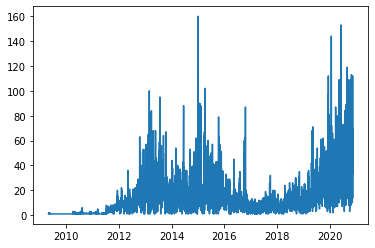

In [89]:
Date_number = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                      .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                      .map(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() if datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() else None)\
                      .map(lambda date: (date, 1))\
                      .reduceByKey(lambda x,y : x+y)\
                      .sortBy(lambda tup : tup[1], ascending=False)

sqlContext = SQLContext(sc)
schemaPeople = sqlContext.createDataFrame(Date_number)
schemaPeople.createOrReplaceTempView("Date_number")

df = schemaPeople.select("*").sort('_1').toPandas()

plt.plot(df["_1"], df["_2"])
plt.show()

# All of works in a function

Finally, we create a function that centralize all of works and which will allow the user to choose the analysis according to dates

In [88]:
def test(from_ = None, to_ = None):
    if(datetime.datetime.strptime(to_, '%d/%m/%Y').date() <= datetime.datetime.strptime('4/5/2009', '%d/%m/%Y').date()):
        return 'Pas de tweets pour cette période'

In [109]:
def temp_analysis(from_ = None, to_ = None): 
    
    if(datetime.datetime.strptime(to_, '%d/%m/%Y').date() < datetime.datetime.strptime('4/5/2009', '%d/%m/%Y').date()):
        return 'Pas de tweets pour cette période'
    elif(datetime.datetime.strptime(from_, '%d/%m/%Y').date() > datetime.datetime.strptime('16/11/2020', '%d/%m/%Y').date()):
        return 'Pas de tweets pour cette période'
    
    if from_ and to_:
        Date_temp = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                            .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                            .filter(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() >= datetime.datetime.strptime(from_, '%d/%m/%Y').date()
                            and datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() <= datetime.datetime.strptime(to_, '%d/%m/%Y').date())
        
        Date_number = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                              .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                              .map(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() 
                                   if datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() >= datetime.datetime.strptime(from_, '%d/%m/%Y').date()
                                   and datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() <= datetime.datetime.strptime(to_, '%d/%m/%Y').date() else None)\
                              .filter(lambda element : element != None)\
                              .map(lambda date: (date, 1))\
                              .reduceByKey(lambda x,y : x+y)\
                              .sortBy(lambda tup : tup[1], ascending=False)
    elif from_:
        Date_temp = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                            .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                            .filter(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() >= datetime.datetime.strptime(from_, '%d/%m/%Y').date())
        
        Date_number = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                              .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                              .map(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() 
                                   if datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() >= datetime.datetime.strptime(from_, '%d/%m/%Y').date()
                                   else None)\
                              .filter(lambda element : element != None)\
                              .map(lambda date: (date, 1))\
                              .reduceByKey(lambda x,y : x+y)\
                              .sortBy(lambda tup : tup[1], ascending=False)
        
    elif to_: 
        Date_temp = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                            .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                            .filter(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() <= datetime.datetime.strptime(to_, '%d/%m/%Y').date())
        
        Date_number = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                              .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                              .map(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() 
                                   if datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() <= datetime.datetime.strptime(to_, '%d/%m/%Y').date() else None)\
                              .filter(lambda element : element != None)\
                              .map(lambda date: (date, 1))\
                              .reduceByKey(lambda x,y : x+y)\
                              .sortBy(lambda tup : tup[1], ascending=False)
    else: 
        Date_temp = rdd_mbox
        
        Date_number = rdd_mbox.filter(lambda tweet : re.search('\d{2}/\d{2}/\d{4}', tweet) )\
                              .filter(lambda tweet : int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) >= 1 and int(re.search('\d{2}/\d{2}/\d{4}', tweet).group()[3:5]) <= 12)\
                              .map(lambda tweet : datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() if datetime.datetime.strptime(re.search('\d{2}/\d{2}/\d{4}', tweet).group(), '%d/%m/%Y').date() else None)\
                              .filter(lambda element : element != None)\
                              .map(lambda date: (date, 1))\
                              .reduceByKey(lambda x,y : x+y)\
                              .sortBy(lambda tup : tup[1], ascending=False)
         
    ###########
    
    sqlContext = SQLContext(sc)
    schemaPeople = sqlContext.createDataFrame(Date_number)
    schemaPeople.createOrReplaceTempView("Date_number")

    df = schemaPeople.select("*").sort('_1').toPandas()

    plt.plot(df["_1"], df["_2"])
    
    print('Tweet number per day\n')
    plt.show()
    
    print('\n')
       
    ###########
    
    rdd_clean_tweet_temp = Date_temp.map(lambda tweet : clean_tweet_(tweet))
    nb_twitter_temp = rdd_clean_tweet_temp.count()
    ##########
    
    rdd_clean_tweet_words_temp = Date_temp.map(lambda tweet : clean_tweet_(tweet).split(' '))
    
    ##########
    
    rdd_clean_tweet_stop_words_temp = rdd_clean_tweet_words_temp.map(lambda tweet_words : remove_stop_words(tweet_words))
    
    ##########
    
    rdd_clean_tweet_stop_words_flat_temp = rdd_clean_tweet_words_temp.flatMap(lambda tweet_words : remove_stop_words(tweet_words))
   
    ##########
    
    rdd_sentiment_analysis_temp = rdd_clean_tweet_temp.map(lambda tweet : sentiment_analysis_(tweet))
    
    ##########
    
    Global_sentiment_temp = rdd_sentiment_analysis_temp.map(lambda word: (word, 1)) \
                                                   .reduceByKey(lambda x,y : x+y) \
                                                   .sortBy(lambda tuple: tuple[1], ascending=False)
    Top_sentiment_temp = Global_sentiment_temp.take(3)
    
    Sentiment_1 = Top_sentiment_temp[0][0]
    Sentiment_2 = Top_sentiment_temp[1][0]
    Sentiment_3 = Top_sentiment_temp[2][0]
    Sentiment_score_1 = (Top_sentiment_temp[0][1]/nb_twitter_temp)*100
    Sentiment_score_2 = (Top_sentiment_temp[1][1]/nb_twitter_temp)*100
    Sentiment_score_3 = (Top_sentiment_temp[2][1]/nb_twitter_temp)*100

    labels = Sentiment_1, Sentiment_2, Sentiment_3
    sizes = [Sentiment_score_1, Sentiment_score_2, Sentiment_score_3]

    print('Global sentiment per tweet :\n')
    
    print(Global_sentiment_temp.take(3))
    
    explode = (0, 0, 0)  

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
    
    ##########
    
    # initialize an rdd with key/value for counting each word in the file 
    rdd_clean_tweet_stop_words_kv_temp = rdd_clean_tweet_stop_words_flat_temp.map(lambda word: (word, 1))
    
    # rdd_positive_words_product_kv RDD should contain positive words in the product review file
    rdd_positive_words_tweet_kv_temp = rdd_clean_tweet_stop_words_kv_temp.join(rdd_positive_words_kv)
    
    # use the mapValues transformation to assign a default count of 1 for each positive word
    rdd_positive_words_tweet_kv_temp = rdd_positive_words_tweet_kv_temp.mapValues(lambda tuple: 1)
    
    # rdd_positive_words_product_count_kv should contain the number of occurences (count) of each positive word in product reviews
    rdd_positive_words_tweet_count_kv_temp = rdd_positive_words_tweet_kv_temp.reduceByKey(lambda x,y : x+y)
    
    # rdd_positive_words_product_count_kv_ordered should contain the previous RDD in descending order based on the count
    rdd_positive_words_tweet_count_kv_ordered_temp = rdd_positive_words_tweet_count_kv_temp.sortBy(lambda tuple: tuple[1], ascending=False)
    list_top_positives_words_temp = rdd_positive_words_tweet_count_kv_ordered_temp.take(25)
    
    print('Top Positive Words')
    plot_cloud(list_top_positives_words_temp)
    
    
    ##########
    # rdd_negative_words_product_kv RDD should contain negative words in the product review file
    rdd_negative_words_tweet_kv_temp = rdd_clean_tweet_stop_words_kv_temp.join(rdd_negative_words_kv)
    
    # use the mapValues transformation to assign a default count of 1 for each positive word 
    rdd_negative_words_tweet_kv_temp = rdd_negative_words_tweet_kv_temp.mapValues(lambda tuple: 1)
    
    # rdd_negative_words_product_count_kv should contain the number of occurences (count) of each negative word in product reviews
    rdd_negative_words_tweet_count_kv_temp = rdd_negative_words_tweet_kv_temp.reduceByKey(lambda x,y : x+y)
    
    # rdd_negative_words_product_count_kv_ordered should contain the previous RDD in descending order based on the count
    rdd_negative_words_tweet_count_kv_ordered_temp = rdd_negative_words_tweet_count_kv_temp.sortBy(lambda tuple: tuple[1], ascending=False)
    list_top_negatives_words_temp = rdd_negative_words_tweet_count_kv_ordered_temp.take(25)
    
    print('Top Negative Words')
    plot_cloud(list_top_negatives_words_temp)
    print('\n')
    
    # call the plot_opinion function to plot our product reviews top positives and negatives opinions
    
    print('Plot opinion')
    plot_opinion(list_top_positives_words_temp, list_top_negatives_words_temp)
    
    
    ##########
    
    contextual_words_temp = rdd_clean_tweet_stop_words_flat_temp.subtract(rdd_negative_words).subtract(rdd_positive_words)
    
    # use multiple transformations for counting each contextual word in the product review file, sorted in ascending order based 
    # on the count
    contextual_words_count_ordered_temp = contextual_words_temp.map(lambda word: (word, 1))\
                                                               .reduceByKey(lambda x,y : x+y)\
                                                               .sortBy(lambda tuple: tuple[1], ascending=False)\
                                                               .filter(lambda tuple: tuple[0] != '<url>')

    list_top_contextual_words_temp = contextual_words_count_ordered_temp.take(50) 
    
    print('Top contextual words')
    plot_cloud(list_top_contextual_words_temp)


    
    
    ##########
    hastag_temp = Date_temp.flatMap(lambda tweet : extract_startwith(tweet,'#'))\
                        .map(lambda word: (word, 1))\
                        .mapValues(lambda tuple: 1)\
                        .reduceByKey(lambda x,y : x+y)\
                        .sortBy(lambda tuple: tuple[1], ascending=False)
    list_top_hastag_temp = hastag_temp.take(25)
    
    print('Top hastags')
    plot_cloud(list_top_hastag_temp)

    
    ##########
    
    
    RT_from_temp = Date_temp.flatMap(lambda tweet :extract_startwith(tweet,'@'))\
                    .map (lambda tweet :clean_rt(tweet))\
                    .map(lambda word: (word, 1))\
                    .mapValues(lambda tuple: 1)\
                    .reduceByKey(lambda x,y : x+y)\
                    .sortBy(lambda tuple: tuple[1], ascending=False)
    
    list_top_retweet_from_temp = RT_from_temp.take(25)
    
    print('Top retweets')
    plot_cloud(list_top_retweet_from_temp)

    ##########
    
    emoji_temp = Date_temp.flatMap(lambda tweet : extract_emojis(tweet))\
                        .map(lambda word: (word, 1))\
                        .mapValues(lambda tuple: 1)\
                        .reduceByKey(lambda x,y : x+y)\
                        .sortBy(lambda tuple: tuple[1], ascending=False)
    list_top_emoji_temp = emoji_temp.take(25)
    
    print('Top emojis')
    print(list_top_emoji_temp)
   
    ##########
    
    RT_temp = Date_temp.map(lambda tweet : check_startwith(tweet, 'RT'))\
                    .map(lambda word: (word, 1))\
                    .mapValues(lambda tuple: 1)\
                    .reduceByKey(lambda x,y : x+y)\
                    .sortBy(lambda tuple: tuple[1], ascending=False)
    list_RT_temp = RT_temp.take(2)
    
    
    RT_1 = list_RT_temp[0][0]
    RT_2 = list_RT_temp[1][0]
    
    RT_1_frequency = (list_RT_temp[0][1]/nb_twitter_temp)*100
    RT_2_frequency = (list_RT_temp[1][1]/nb_twitter_temp)*100
    
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = RT_1, RT_2
    sizes = [RT_1_frequency, RT_2_frequency]
    explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
    
    print('RT proportion')
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.show()
    
    
    

Tweet number per day



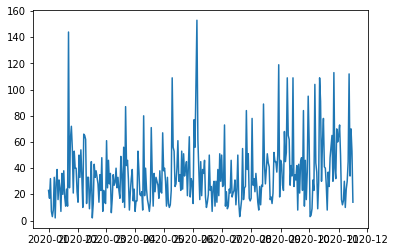



Global sentiment per tweet :

[('positive', 4743), ('neutral', 3767), ('negative', 2824)]


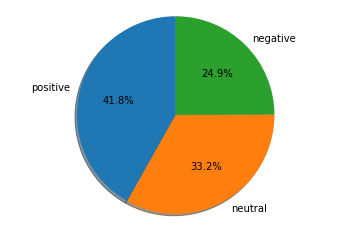

Top Positive Words


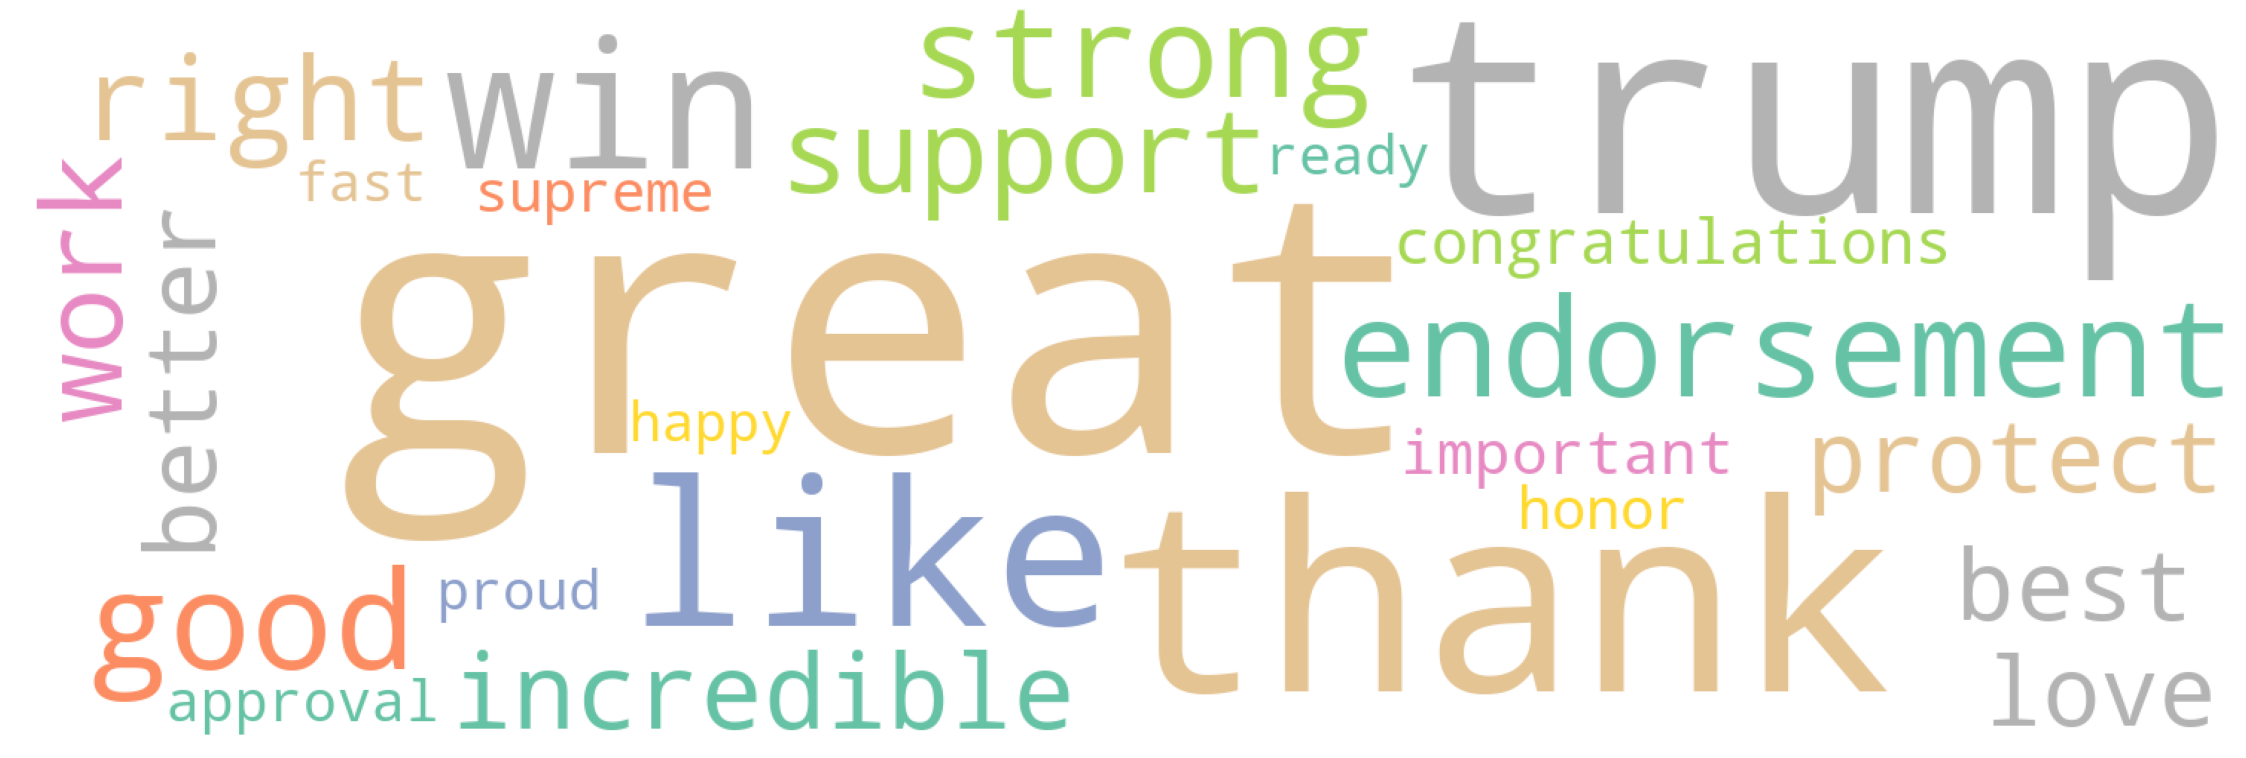

Top Negative Words


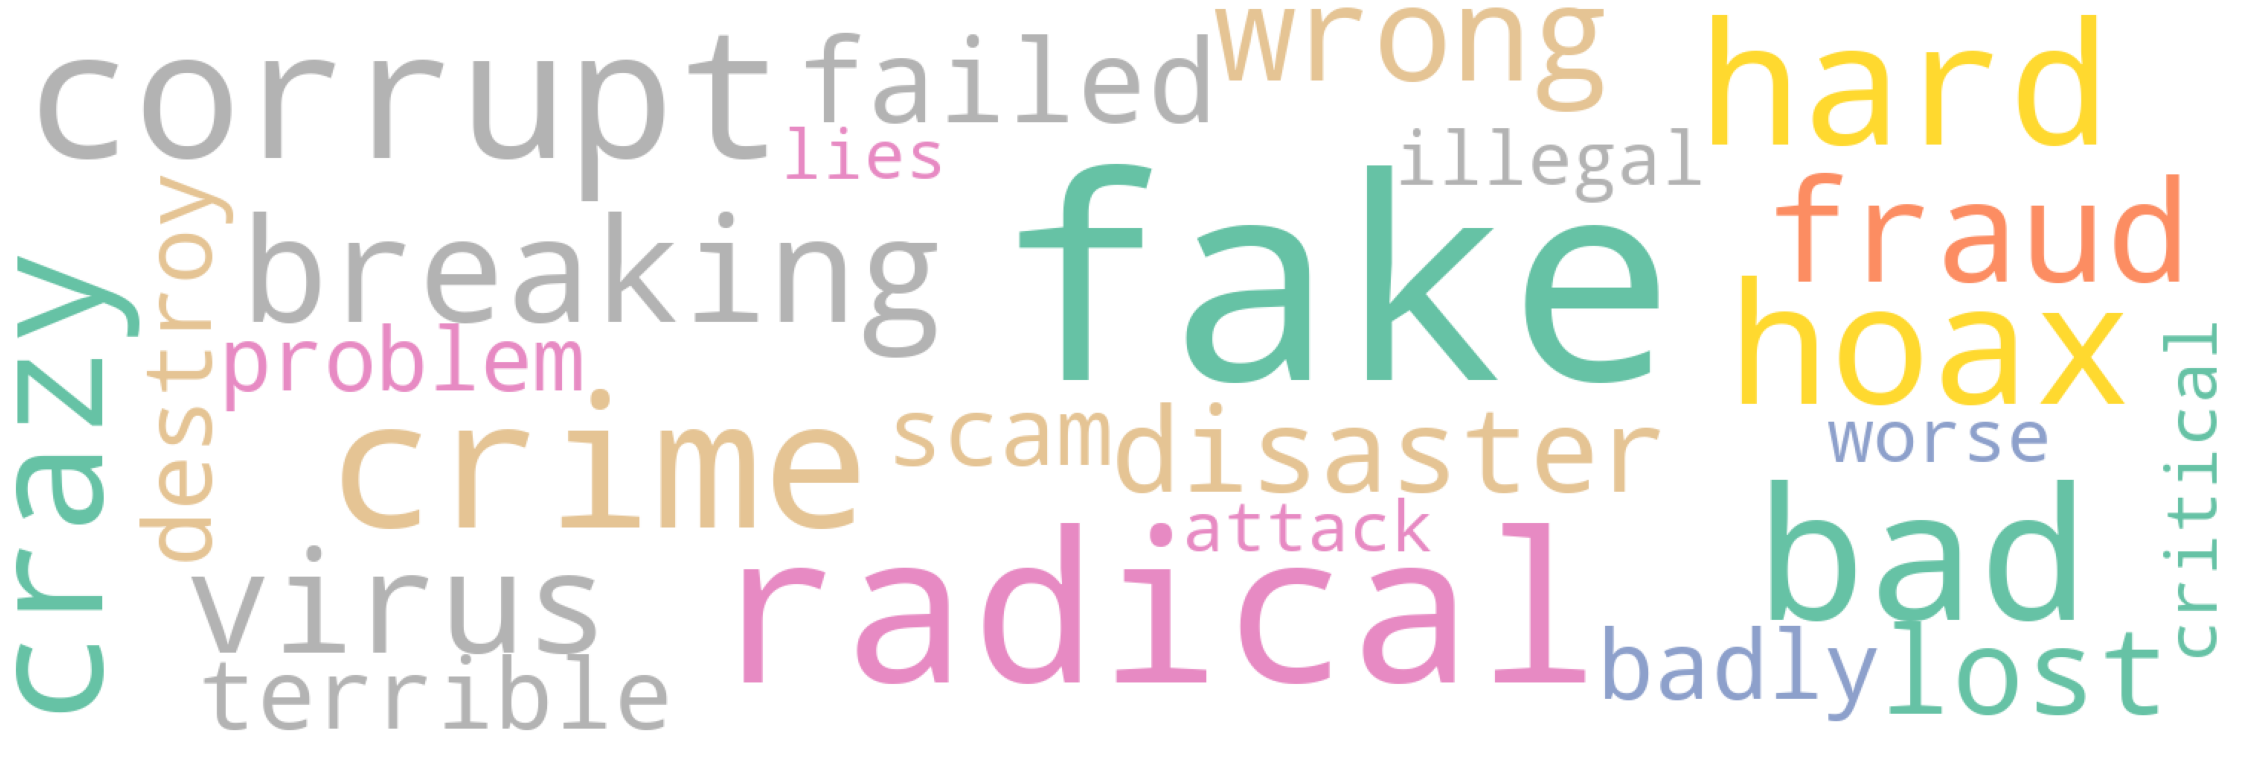



Plot opinion


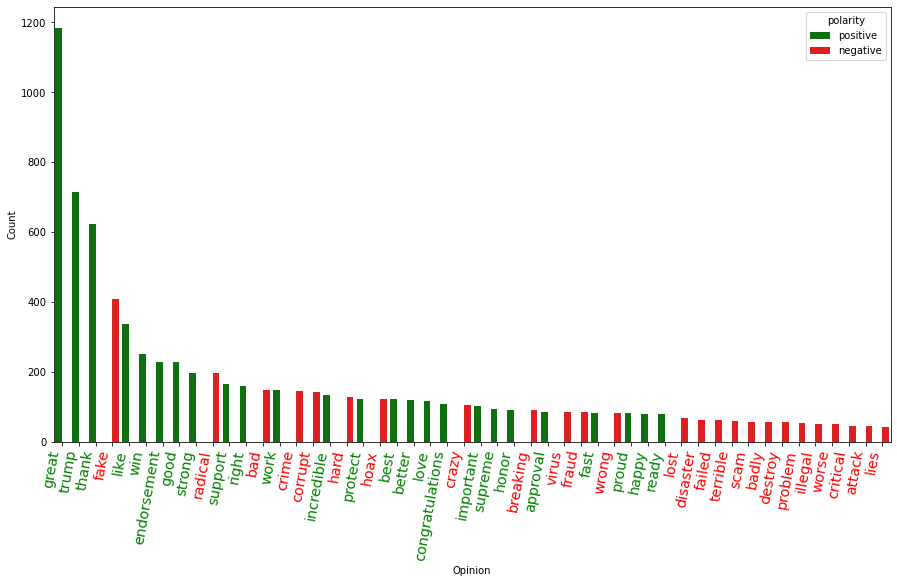

Top contextual words


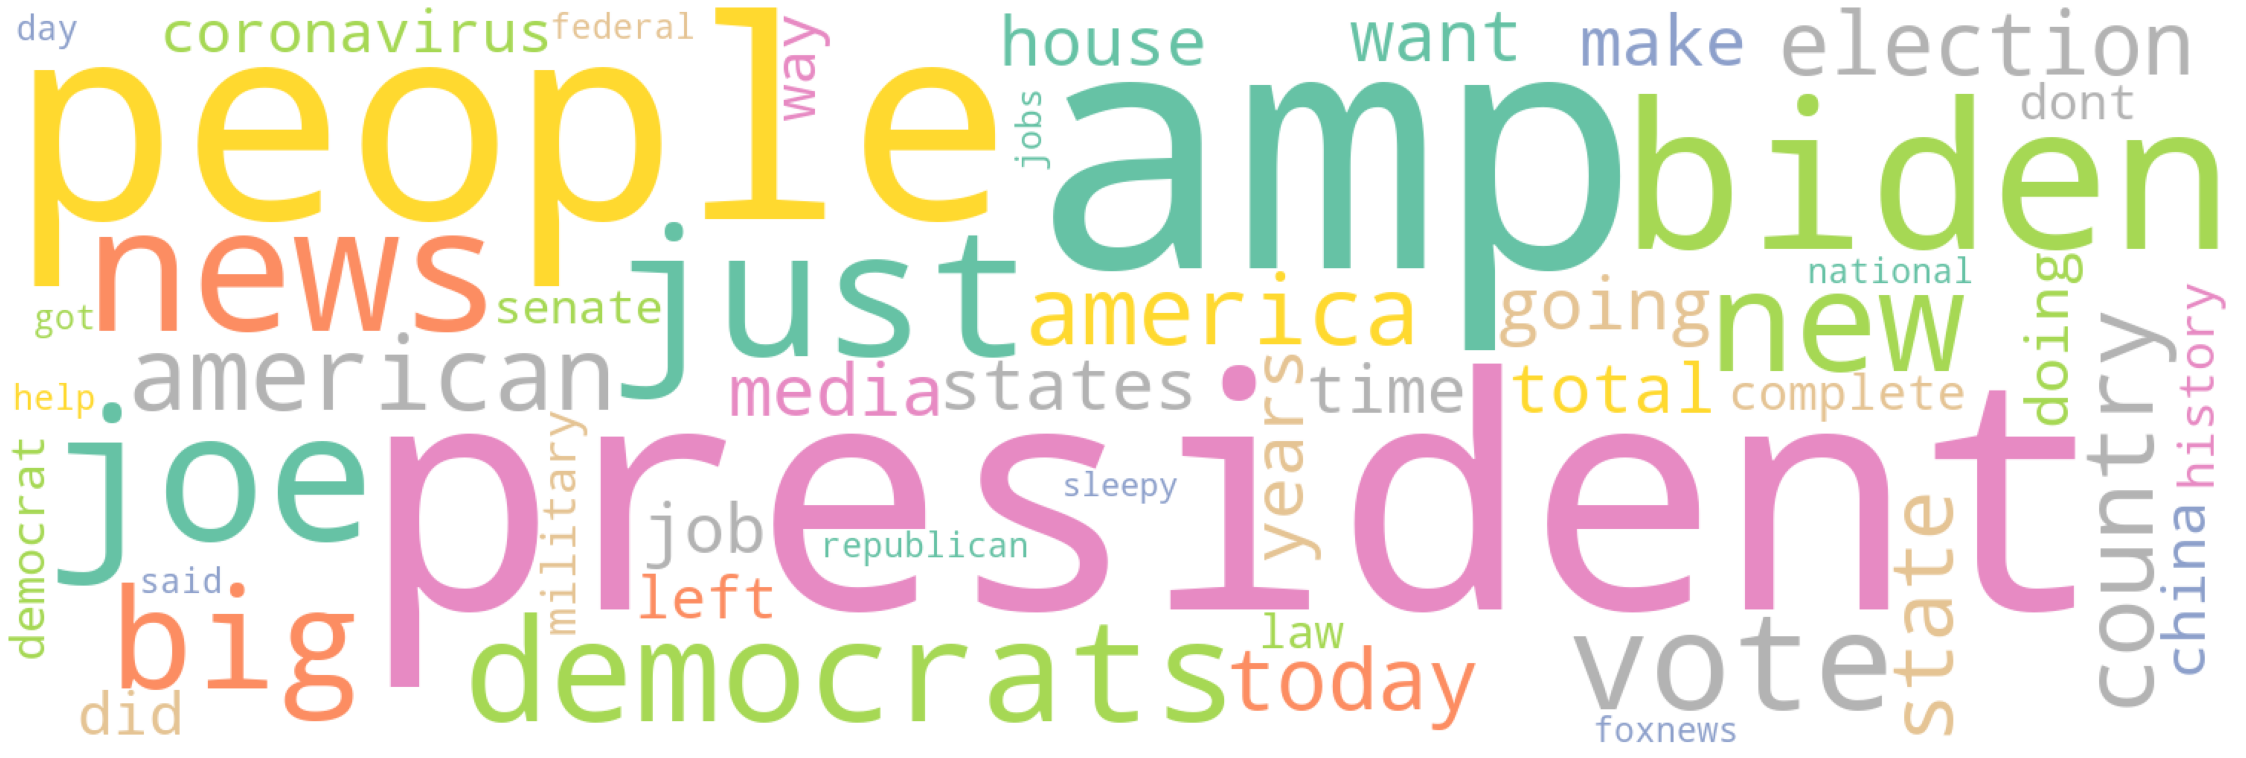

Top hastags


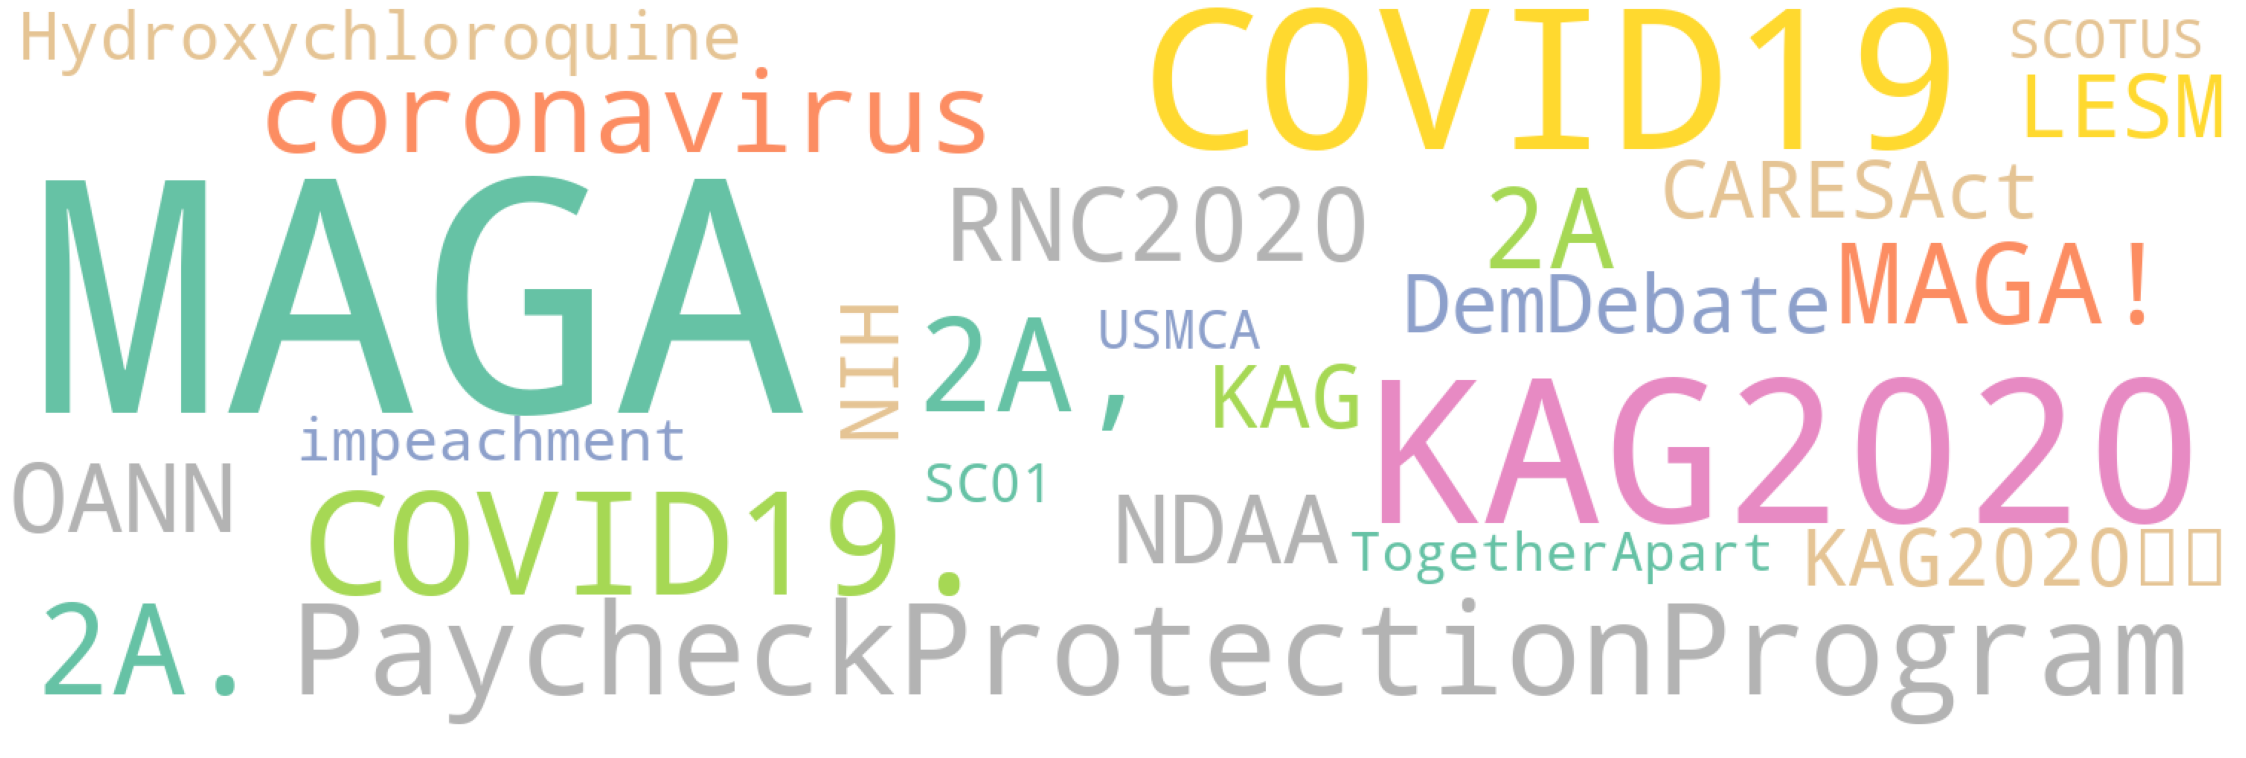

Top retweets


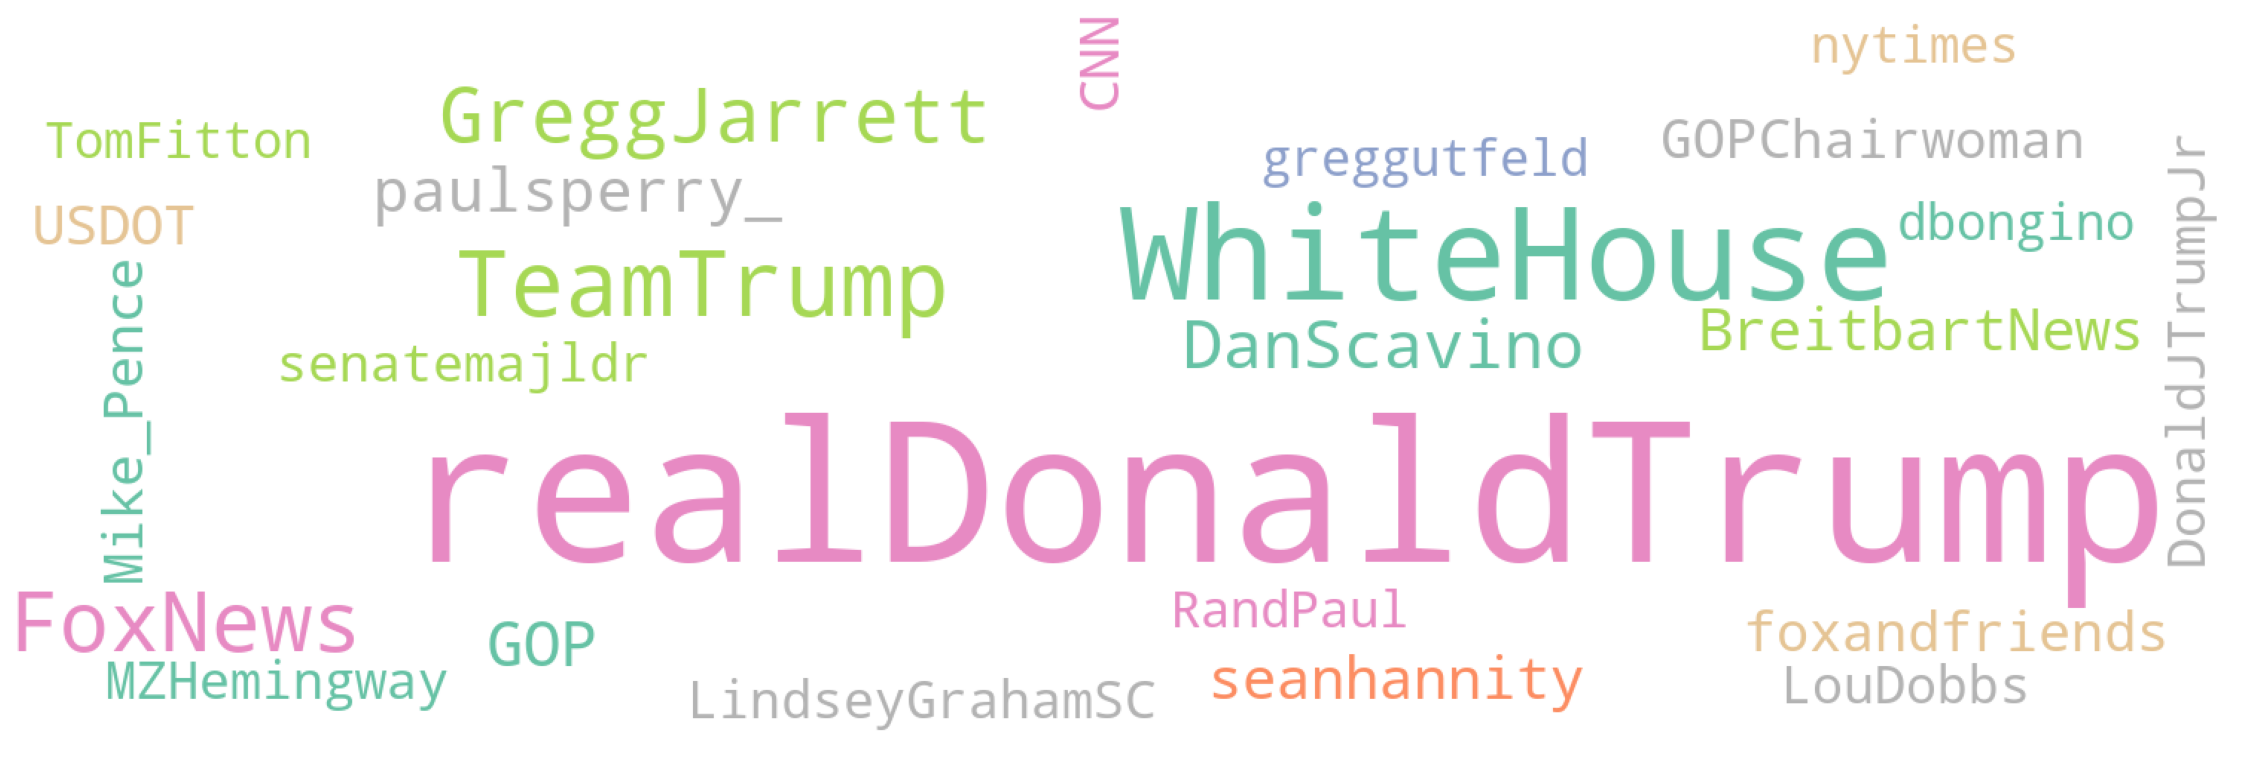

Top emojis
[('🇺', 129), ('🇸', 127), ('🚨', 44), ('👇', 40), ('🏻', 24), ('⬇', 17), ('✅', 17), ('🏼', 16), ('😂', 13), ('🤣', 13), ('🔥', 12), ('👏', 10), ('➡', 8), ('🤦', 8), ('▶', 8), ('👀', 8), ('♂', 7), ('❤', 7), ('🦅', 6), ('🤔', 6), ('🙏', 6), ('🧐', 5), ('🌐', 5), ('🇲', 4), ('🙌', 4)]
RT proportion


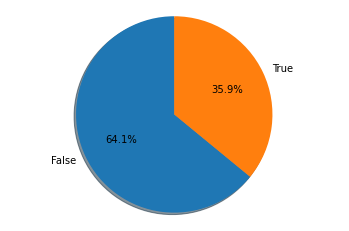

In [112]:
temp_analysis('01/01/2020', '25/12/2020')